In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [2]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])

In [3]:
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()

project to new coords
interpolate driver to station locations


In [4]:
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.get_modelled_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas', cumulative=True, thinning_parameter=tp)
Maize_set.subsample_X_y(subsample_frac=0.8)
Maize_set.decision_tree(md=3)#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.ML_modelled_observed()

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


In [16]:
# data rows of csv file
coords = Maize_set.phen_data[['lat', 'lon', 'Stations_id']].drop_duplicates().values
# using the savetxt
# from the numpy module
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords.csv",
        coords,
        delimiter =", ",
        fmt ='% s')

In [4]:
def RMSE_ML_model(ds, phases, training_means):
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    for phase_index, phase in enumerate(phases):
        print('Phase: ' + str(phase))
        ML_residuals = ds[f'ML prediction emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        ML_residuals = ML_residuals.where(np.abs(ML_residuals) < 60)
        model_residuals = ds[f'modelled time emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        model_residuals = model_residuals.where(np.abs(model_residuals) < 60)
        residuals_to_average = training_means[phase_index] - ds[f'observed time emergence to {phase}']
        residuals_to_average = residuals_to_average.where(np.abs(model_residuals) < 60)
        print('RMSE for ML is ' + str(np.round(RMSE(ML_residuals), decimals=1)))
        print('RMSE for model is ' + str(np.round(RMSE(model_residuals), decimals=1)))
        print('RMSE to training mean is ' + str(np.round(RMSE(residuals_to_average), decimals=1)))

In [12]:
phase_list = ['beginning of flowering', 'yellow ripeness']
training_means = []
for phase in phase_list:
    training_means.append(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].mean())
    print(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].count())
RMSE_ML_model(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)
#plot_error_distn(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)

9872
9872
Phase: beginning of flowering
RMSE for ML is 10.2
RMSE for model is 14.2
RMSE to training mean is 10.2
Phase: yellow ripeness
RMSE for ML is 15.3
RMSE for model is 27.5
RMSE to training mean is 13.7


In [ ]:
phase_list = ['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
#Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2020].dropna()['lat'], Maize_set.ds_observed.loc[2020].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [ ]:
tree_rules = tree.export_text(Maize_set.regr, feature_names=[f'Day {tp*i} cum. temp' for i in range(np.int64(np.floor(200/tp)))])
print(Maize_set.y_for_ML)
print(tree_rules)

In [2]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

    def __init__(self, address):
        self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.phase_list = [] #list of phases to consider
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            self.phen_data = self.phen_data.drop(drop_name, axis = 1)
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035):
        ## Puts pandas phenological frame into driver xarray and aligns the two
        self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        self.just_emergence = self.just_emergence.where(self.just_emergence['Eintrittsdatum'] > np.datetime64('2022-01-01')).dropna()
        x_coords = self.just_emergence['lon'].values
        y_coords = self.just_emergence['lat'].values
        station_ids = np.int64(self.just_emergence['Stations_id'].values)
        x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
        #Makes an array to put into GDD model
        print('project to new coords')
        x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
        print('interpolate driver to station locations')
        self.x_epsg = x_epsg
        self.y_epsg = y_epsg
        # Working in xarray (not pandas) after this point:
        self.GDD_driver_data = dataset_fctns.interpolate_xy(x_epsg, y_epsg, self.T_mean)
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", stations))
        self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])

        
    
    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2019)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'Eintrittsdatum']])
        time_station = time_station.rename({'index':'Emergence observation', 'Eintrittsdatum':'time'})
        time_station['time'] += np.timedelta64(12, 'h')
        print(time_station)
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        #Run model
        for day in range(200):
            print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.just_emergence['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.just_emergence['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False):
        observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
        self.ds_observed = pd.DataFrame({f'observed time emergence to {self.phase_list[0]}': observed_to_first_stage})
        for phase in self.phase_list[1:]:
            self.ds_observed[f'observed time emergence to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
        self.ds_observed = self.ds_observed.reset_index()
        self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        self.ds_observed = self.ds_observed.merge(self.just_emergence[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.concat([self.phase_dates_array, self.ds_observed.drop_duplicates()], axis = 1)

    
    
    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_18504\3188619908.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


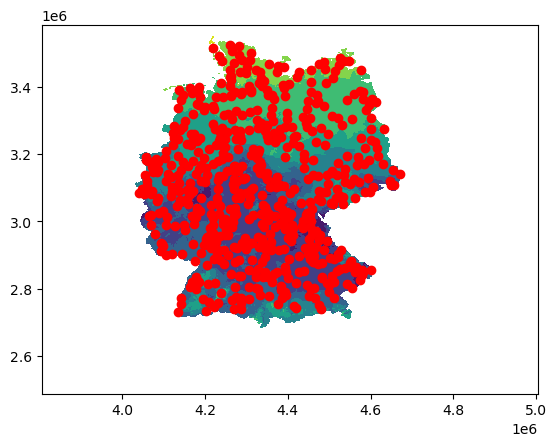

In [11]:
fig, axs = plt.subplots()
axs.contourf(Maize_set.T_mean['x'], Maize_set.T_mean['y'], Maize_set.T_mean['tas'].isel(time = 0).values)
for index, x in enumerate(Maize_set.x_epsg):
    axs.plot(x, Maize_set.y_epsg[index], 'ro')

In [10]:
hmm = make_input_array(Maize_set)

project to new coords
interpolate driver to station locations


In [13]:
hmm.driver_data_for_ML

AttributeError: 'Phenology_set' object has no attribute 'driver_data_for_ML'

In [7]:
## Functions for ML ##    
def put_obs_data_in_input_array(self): #, predictor_days = 200
    y_data = {}
    for phase_time in self.ds_observed.columns:
        if phase_time != 'lat' and phase_time != 'lon':
            y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
    #print(y_data)
    obs_data = xr.Dataset(data_vars = y_data,
                            coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0))),
                                    'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1)))}
                                    )
    #print(obs_data)
    obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.reset_index('modelpoint')
    #self.GDD_driver_data['Stations_id'] = self.GDD_driver_data['Stations_id'].astype(np.int64)
    #self.GDD_driver_data['Referenzjahr'] = self.GDD_driver_data['Referenzjahr'].astype(np.int64)
    self.GDD_driver_data = self.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = xr.merge([self.GDD_driver_data, obs_data], join='left') #self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
    self.GDD_driver_data = self.GDD_driver_data.dropna('modelpoint') #self.data_for_ML = self.data_for_ML.dropna('modelpoint')


In [89]:
def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
    self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
    self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
    self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
    self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
    time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
    time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
    time_station = time_station.drop_vars('index')
    time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
    time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
    time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] + pd.Timedelta(12, 'h')
    time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
    time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
    self.time_station = time_station
    self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
    self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
    self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
    self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
    self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
    self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML['tas'].unstack(),
                                          self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                          self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                          self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
    self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
    self.driver_frame_for_ML = pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
    #self.X_for_ML = self.driver_data_for_ML[:predictor_days, :].values.T
    #if cumulative:
    #    self.X_for_ML = np.cumsum(self.X_for_ML, axis=1)
    #if thinning_parameter != 1:
    #    self.X_for_ML = self.X_for_ML[:, ::thinning_parameter]
    #self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns[:-2]])[:predictor_days, :].T
    #for station in self.just_emergence['Stations_id'].unique():
    #    just_station = self.just_emergence.where(self.just_emergence['Stations_id'] == station).dropna()
    #    for year in just_station['Referenzjahr'].unique():
    #        just_station_year = just_station.where(just_station['Referenzjahr'] == year).dropna()
    #        print(just_station_year)
    #        station_data = self.GDD_driver_data.sel({'Stations_id':station})
    #        #, time = slice(just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h'), just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h') + pd.Timedelta(predictor_days, 'D')))
    #        print(station_data)
    return self

In [90]:
hmm = get_X_y_for_ML(Maize_set, start_year = 2022, end_year=2025)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_18504\3265743616.py:16: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})


In [107]:
pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)

,Referenzjahr,Stations_id,tas day 0,tas day 1,tas day 2,tas day 3,tas day 4,tas day 5,tas day 6,tas day 7,...,tas day 196,tas day 197,tas day 198,tas day 199,lat,lon,WC SOS,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,emergence date
0,2022,7521.0,7.239809,6.500000,7.523182,8.411591,7.939809,8.939809,8.900000,9.411591,...,15.800000,12.560192,13.720383,12.100000,54.4333,9.8167,2022-04-15 12:00:00,75.0,122.0,2022-05-08
1,2022,7532.0,8.984424,8.300000,7.500000,8.500000,10.100000,9.800000,10.000000,10.131152,...,15.100000,15.500000,13.000000,14.300000,54.4000,8.7667,2022-04-14 12:00:00,86.0,126.0,2022-05-11
2,2022,7592.0,7.725968,6.800000,8.000000,9.190843,8.933626,9.045421,9.045421,9.900000,...,16.100000,14.400000,13.745157,12.100000,53.4833,10.6333,2022-04-15 12:00:00,NaN,NaN,2022-05-13
3,2022,7608.0,7.604409,6.604409,7.952205,9.079673,8.552205,8.833753,8.952205,9.704409,...,16.300000,14.500000,13.990324,12.000000,53.5000,10.4833,2022-04-15 12:00:00,NaN,NaN,2022-05-10
4,2022,7623.0,9.056106,7.800000,7.425676,8.000000,9.425676,9.000000,9.600000,9.600000,...,15.000000,15.600000,12.500000,13.100000,54.6667,9.1333,2022-04-14 12:00:00,75.0,123.0,2022-05-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2024,19587.0,7.120814,4.850861,4.426292,4.596245,5.150861,3.635838,4.150861,4.180908,...,11.834731,10.800000,10.000000,9.500000,48.7091,9.2147,2024-04-16 12:00:00,NaN,NaN,NaT
1796,2024,19588.0,5.343996,6.343996,6.000000,5.143996,5.415994,3.171998,2.200000,3.571998,...,12.000000,11.890781,11.743996,9.815994,50.8063,10.2294,2024-04-16 12:00:00,NaN,NaN,NaT
1797,2024,19699.0,6.270474,6.700000,6.270474,5.987307,4.200000,3.200000,3.886393,4.686393,...,13.093197,11.500000,9.495769,7.993197,51.0418,11.0062,2024-04-17 12:00:00,NaN,NaN,NaT
1798,2024,19700.0,3.506406,3.496677,2.648339,2.117529,1.202239,0.463629,1.717529,2.042777,...,10.671429,10.161700,7.500000,6.107800,50.4316,11.9443,2024-04-17 12:00:00,NaN,NaN,NaT


In [98]:
pd.concat([hmm.driver_frame_for_ML, hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id'])], axis=1, )
hmm.driver_frame_for_ML.join(hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id']), how='left')

ValueError: columns overlap but no suffix specified: Index(['lat', 'lon'], dtype='object')

In [88]:
hmm.driver_frame_for_ML.index.get_level_values(0) = hmm.driver_frame_for_ML.index.get_level_values(0).year#['Referenzjahr']

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (263131851.py, line 1)

In [73]:
obs = xr.Dataset.from_dataframe(hmm.ds_observed)
obs = obs.reset_index('index')
obs = obs.assign_coords({'Stations_id':obs['Stations_id'],'Referenzjahr':obs['Referenzjahr']})
obs = obs.set_xindex(['Stations_id', 'Referenzjahr'])


In [80]:
hmm.driver_data_for_ML

<xarray.DataArray 'tas' (Referenzjahr: 3, time_from_SOS: 200, Stations_id: 600)> Size: 3MB
array([[[ 7.23980862,  8.98442404,  7.72596838, ...,  7.69485536,
          6.00000009,  9.14249779],
        [ 6.5000001 ,  8.30000012,  6.8000001 , ...,  8.00000012,
          5.45389999,  8.27735449],
        [ 7.52318169,  7.50000011,  8.00000012, ...,  7.36053208,
          4.80779988,  9.60977796],
        ...,
        [12.56019167, 15.50000023, 14.40000021, ..., 12.60000019,
         11.80802864, 14.03957147],
        [13.72038317, 13.00000019, 13.74515733, ..., 10.00000015,
          8.03860955, 11.994069  ],
        [12.10000018, 14.30000021, 12.10000018, ...,  8.67893619,
          6.72331905, 12.01614312]],

       [[ 8.93980865,  8.31557622,  8.89322072, ...,  8.28639299,
          4.94277741,  8.71357224],
        [ 9.00000013,  9.40000014,  8.42596839, ...,  7.79576892,
          4.49443878,  8.99699535],
        [ 8.45733421, 10.22280144,  8.80000013, ...,  6.19153771,
          4.6888775 ,  9.08800022],
...
        [11.74356472,  8.80000013, 11.90000018, ..., 12.09319661,
          9.53304828, 11.7370006 ],
        [11.50000017, 11.80000018, 12.00000018, ..., 10.9931966 ,
          7.87142903, 10.64249781],
        [ 6.9000001 , 11.60000017,  8.60000013, ...,  8.39319656,
          5.8616998 , 11.79742934]],

       [[ 9.40000014, 12.468848  , 11.50000017, ...,  6.27047377,
          3.50640649, 10.22085764],
        [ 7.20000011,  9.50000014,  8.21918898, ...,  6.7000001 ,
          3.49667729,  5.24842891],
        [ 6.8000001 ,  8.01557621,  6.8000001 , ...,  6.27047377,
          2.64833866,  5.99271472],
        ...,
        [11.00000016, 11.60000017, 10.65193669, ..., 11.50000017,
         10.16169987, 10.55571436],
        [13.3000002 , 12.00000018, 13.1000002 , ...,  9.49576895,
          7.50000011, 11.18206908],
        [11.50000017, 13.4000002 , 12.51417333, ...,  7.99319655,
          6.1077999 , 11.34171514]]])
Coordinates:
    time           (Referenzjahr, time_from_SOS, Stations_id) datetime64[ns] 3MB ...
    lon            (Stations_id) float64 5kB 9.817 8.767 10.63 ... 11.94 9.363
    lat            (Stations_id) float64 5kB 54.43 54.4 53.48 ... 50.43 50.32
    x              (Stations_id) float64 5kB 4.309e+06 4.241e+06 ... 4.276e+06
    y              (Stations_id) float64 5kB 3.481e+06 3.478e+06 ... 3.023e+06
    Stations_id    (Stations_id) float64 5kB 7.521e+03 7.532e+03 ... 1.991e+04
  * Referenzjahr   (Referenzjahr) datetime64[ns] 24B 2022-01-01 ... 2024-01-01
  * time_from_SOS  (time_from_SOS) timedelta64[ns] 2kB 0 days ... 199 days
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Mean Air Temperature
    units:              degree_Celsius
    grid_mapping:       crs
    cell_methods:       time: mean
    units_metadata:     temperature: on-scale
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LAEA",GEOGCS["GCS_ETRS_1989",DATUM[...

In [79]:
hmm.driver_frame_for_ML

tas day 0  tas day 1  tas day 2  tas day 3  \
Referenzjahr Stations_id                                               
2022-01-01   0             7.239809   6.500000   7.523182   8.411591   
             1             8.984424   8.300000   7.500000   8.500000   
             2             7.725968   6.800000   8.000000   9.190843   
             3             7.604409   6.604409   7.952205   9.079673   
             4             9.056106   7.800000   7.425676   8.000000   
...                             ...        ...        ...        ...   
2024-01-01   595           7.120814   4.850861   4.426292   4.596245   
             596           5.343996   6.343996   6.000000   5.143996   
             597           6.270474   6.700000   6.270474   5.987307   
             598           3.506406   3.496677   2.648339   2.117529   
             599          10.220858   5.248429   5.992715   6.163355   

                          tas day 4  tas day 5  tas day 6  tas day 7  \
Referenzjahr Stations_id                                               
2022-01-01   0             7.939809   8.939809   8.900000   9.411591   
             1            10.100000   9.800000  10.000000  10.131152   
             2             8.933626   9.045421   9.045421   9.900000   
             3             8.552205   8.833753   8.952205   9.704409   
             4             9.425676   9.000000   9.600000   9.600000   
...                             ...        ...        ...        ...   
2024-01-01   595           5.150861   3.635838   4.150861   4.180908   
             596           5.415994   3.171998   2.200000   3.571998   
             597           4.200000   3.200000   3.886393   4.686393   
             598           1.202239   0.463629   1.717529   2.042777   
             599           5.163355   5.802144   3.258641   2.526355   

                          tas day 8  tas day 9  ...  tas day 193  tas day 194  \
Referenzjahr Stations_id                        ...                             
2022-01-01   0             9.011591   7.871782  ...    12.871782    12.623182   
             1            10.915576  10.400000  ...    14.500000    13.500000   
             2            10.925968   8.800000  ...    13.000000    11.100000   
             3            10.600000   8.452205  ...    12.900000    11.204409   
             4            10.500000   9.858495  ...    14.367181    13.300000   
...                             ...        ...  ...          ...          ...   
2024-01-01   595           3.575431   5.000000  ...     9.707018    10.375431   
             596           4.200000   5.000000  ...    10.500000    12.300000   
             597           5.995769   9.291538  ...    11.800000    13.900000   
             598           2.617529   6.607800  ...    10.448339    11.053900   
             599           4.381286   4.291498  ...    11.220858    10.220858   

                          tas day 195  tas day 196  tas day 197  tas day 198  \
Referenzjahr Stations_id                                                       
2022-01-01   0              14.500000    15.800000    12.560192    13.720383   
             1              13.300000    15.100000    15.500000    13.000000   
             2              14.059595    16.100000    14.400000    13.745157   
             3              14.100000    16.300000    14.500000    13.990324   
             4              13.025676    15.000000    15.600000    12.500000   
...                               ...          ...          ...          ...   
2024-01-01   595            11.705791    11.834731    10.800000    10.000000   
             596            12.500000    12.000000    11.890781    11.743996   
             597            12.300000    13.093197    11.500000     9.495769   
             598            11.261700    10.671429    10.161700     7.500000   
             599            11.920858    11.410212    10.555714    11.182069   

                          tas day 199      lat      lon  

In [76]:
hmm.ds_observed.set_index(['Stations_id', 'Referenzjahr']).loc[hmm]


,,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date
Stations_id,Referenzjahr,,,,,
7617.0,1951.0,29.0,NaN,54.6167,9.0333,NaT
7899.0,1951.0,80.0,NaN,52.0833,9.5667,NaT
8137.0,1951.0,50.0,NaN,52.8667,9.6000,NaT
8191.0,1951.0,54.0,NaN,53.2667,10.1167,NaT
8234.0,1951.0,98.0,NaN,52.9333,11.1167,NaT
...,...,...,...,...,...,...
19587.0,2022.0,60.0,NaN,48.7091,9.2147,2022-05-17
19588.0,2022.0,NaN,NaN,NaN,NaN,2022-05-11
19699.0,2022.0,NaN,NaN,NaN,NaN,2022-05-07


In [34]:
pd.to_datetime(hmm.time_station.drop_dims('time_from_SOS')['Referenzjahr']).year

Index([2022, 2023, 2024], dtype='int32')

In [35]:
ts = hmm.time_station.drop_dims('time_from_SOS')

In [48]:
ts.reset

<xarray.Dataset> Size: 5kB
Dimensions:       (Referenzjahr: 3, index: 600)
Coordinates:
  * Referenzjahr  (Referenzjahr) int32 12B 2022 2023 2024
Dimensions without coordinates: index
Data variables:
    Stations_id   (index) float64 5kB 7.521e+03 7.532e+03 ... 1.97e+04 1.991e+04

In [36]:
ts['Referenzjahr'] = pd.to_datetime(ts['Referenzjahr']).year

In [41]:
indexer = ts.reset_index('Referenzjahr').reset_coords('Referenzjahr')

In [53]:
obs.reset_index('index')

ValueError: cannot remove index coordinates with reset_coords: {'index'}

In [ ]:
indexer = 

In [44]:
hmm.ds_observed.loc()

<xarray.Dataset> Size: 2MB
Dimensions:                                            (index: 27963)
Coordinates:
  * index                                              (index) int64 224kB 0 ...
Data variables:
    Referenzjahr                                       (index) float64 224kB ...
    Stations_id                                        (index) float64 224kB ...
    observed time emergence to beginning of flowering  (index) float64 224kB ...
    observed time emergence to yellow ripeness         (index) float64 224kB ...
    lat                                                (index) float64 224kB ...
    lon                                                (index) float64 224kB ...
    emergence date                                     (index) datetime64[ns] 224kB ...

In [46]:
obs = obs.set_xindex(['Referenzjahr', 'Stations_id'])
#obs.sel(indexer)

ValueError: Vectorized selection is not available along coordinate 'Referenzjahr' (multi-index level)

In [47]:
obs

<xarray.Dataset> Size: 2MB
Dimensions:                                            (index: 27963)
Coordinates:
  * index                                              (index) object 224kB MultiIndex
  * Referenzjahr                                       (index) float64 224kB ...
  * Stations_id                                        (index) float64 224kB ...
Data variables:
    observed time emergence to beginning of flowering  (index) float64 224kB ...
    observed time emergence to yellow ripeness         (index) float64 224kB ...
    lat                                                (index) float64 224kB ...
    lon                                                (index) float64 224kB ...
    emergence date                                     (index) datetime64[ns] 224kB ...

In [45]:
obs = obs.set_coords(['Referenzjahr', 'Stations_id'])

In [ ]:
    time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'Eintrittsdatum']])
    time_station = time_station.rename({'index':'Emergence observation', 'Eintrittsdatum':'obs_index'})
    time_station['obs_index'] += (np.timedelta64(-49, 'D') + np.timedelta64(-12, 'h'))
    time_station['obs_index'] = time_station['obs_index'].expand_dims(dim={'time':365}).copy()
    time_station = time_station.rename({'obs_index':'time'})
    #time_station.assign_coords({'time_for_inputs':time_station['time']})
    for n in range(365):
        time_station['time'][n] += np.timedelta64(n, 'D')
    print(time_station)
    self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
    self.X_for_ML = self.driver_data_for_ML[:predictor_days, :].values.T
    if cumulative:
        self.X_for_ML = np.cumsum(self.X_for_ML, axis=1)
    if thinning_parameter != 1:
        self.X_for_ML = self.X_for_ML[:, ::thinning_parameter]
    self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns[:-2]])[:predictor_days, :].T

In [26]:
#Maize_set.just_emergence = Maize_set.just_emergence.where(Maize_set.just_emergence['Referenzjahr'] <= 2020)
time_station = xr.Dataset.from_dataframe(Maize_set.just_emergence[['Stations_id', 'Eintrittsdatum']])
time_station = time_station.rename({'index':'Emergence observation', 'Eintrittsdatum':'time'})
time_station['time'] += np.timedelta64(12, 'h')
time_station = time_station.where(np.isin(time_station['time'], Maize_set.GDD_driver_data['time']))
time_station = time_station.where(np.isin(time_station['Stations_id'], Maize_set.GDD_driver_data['Stations_id']))
time_station = time_station.dropna(dim='Emergence observation')
driver_values = self.GDD_driver_data.sel(time_station)
#Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.rename({'modelpoint':'Stations_id'}).set_index(Stations_id='Stations_id')
#time_station_indexer = xr.DataArray(time_station, dims=['modelpoint'])

In [5]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\hyras_meantemp_2017_2025.nc') #C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')


In [ ]:
Maize_set.make_input_array()


In [21]:
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]


In [5]:
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)


<xarray.Dataset> Size: 14kB
Dimensions:                (Emergence observation: 600)
Coordinates:
  * Emergence observation  (Emergence observation) int64 5kB 448 983 ... 411726
Data variables:
    Stations_id            (Emergence observation) float64 5kB 7.521e+03 ... ...
    time                   (Emergence observation) datetime64[ns] 5kB 2022-05...


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7620\3188619908.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.


ValueError: those coordinates already have an index: {'Stations_id'}

In [22]:
Maize_set.get_observed_dataset()

AttributeError: 'Phenology_set' object has no attribute 'phase_dates_array'

In [ ]:
Maize_set.compare_modelled_observed()

In [36]:
observed_dataset.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')